In [1]:

# 📦 Requiere: pip install raphtory pandas matplotlib networkx
import pandas as pd

# Cargar el archivo de latencias percentiles
df = pd.read_csv("kiali_latency_percentiles.csv")
df['timestamp'] = pd.to_datetime(df['timestamp']).astype(int) // 10**9


In [2]:

from raphtory import Graph

# Crear grafo temporal en Raphtory
g = Graph()

for _, row in df.iterrows():
    g.add_node(timestamp=1, id=str(row['source_workload']))
    g.add_node(timestamp=1, id=str(row['destination_workload']))
    g.add_edge(
        timestamp=int(row['timestamp']),
        src=str(row['source_workload']),
        dst=str(row['destination_workload']),
        properties={
            "latency": row["p95_latency"],
            "p90": row["p90_latency"],
            "p50": row["p50_latency"]
        }
    )
print("Grafo creado con Raphtory.")


Grafo creado con Raphtory.


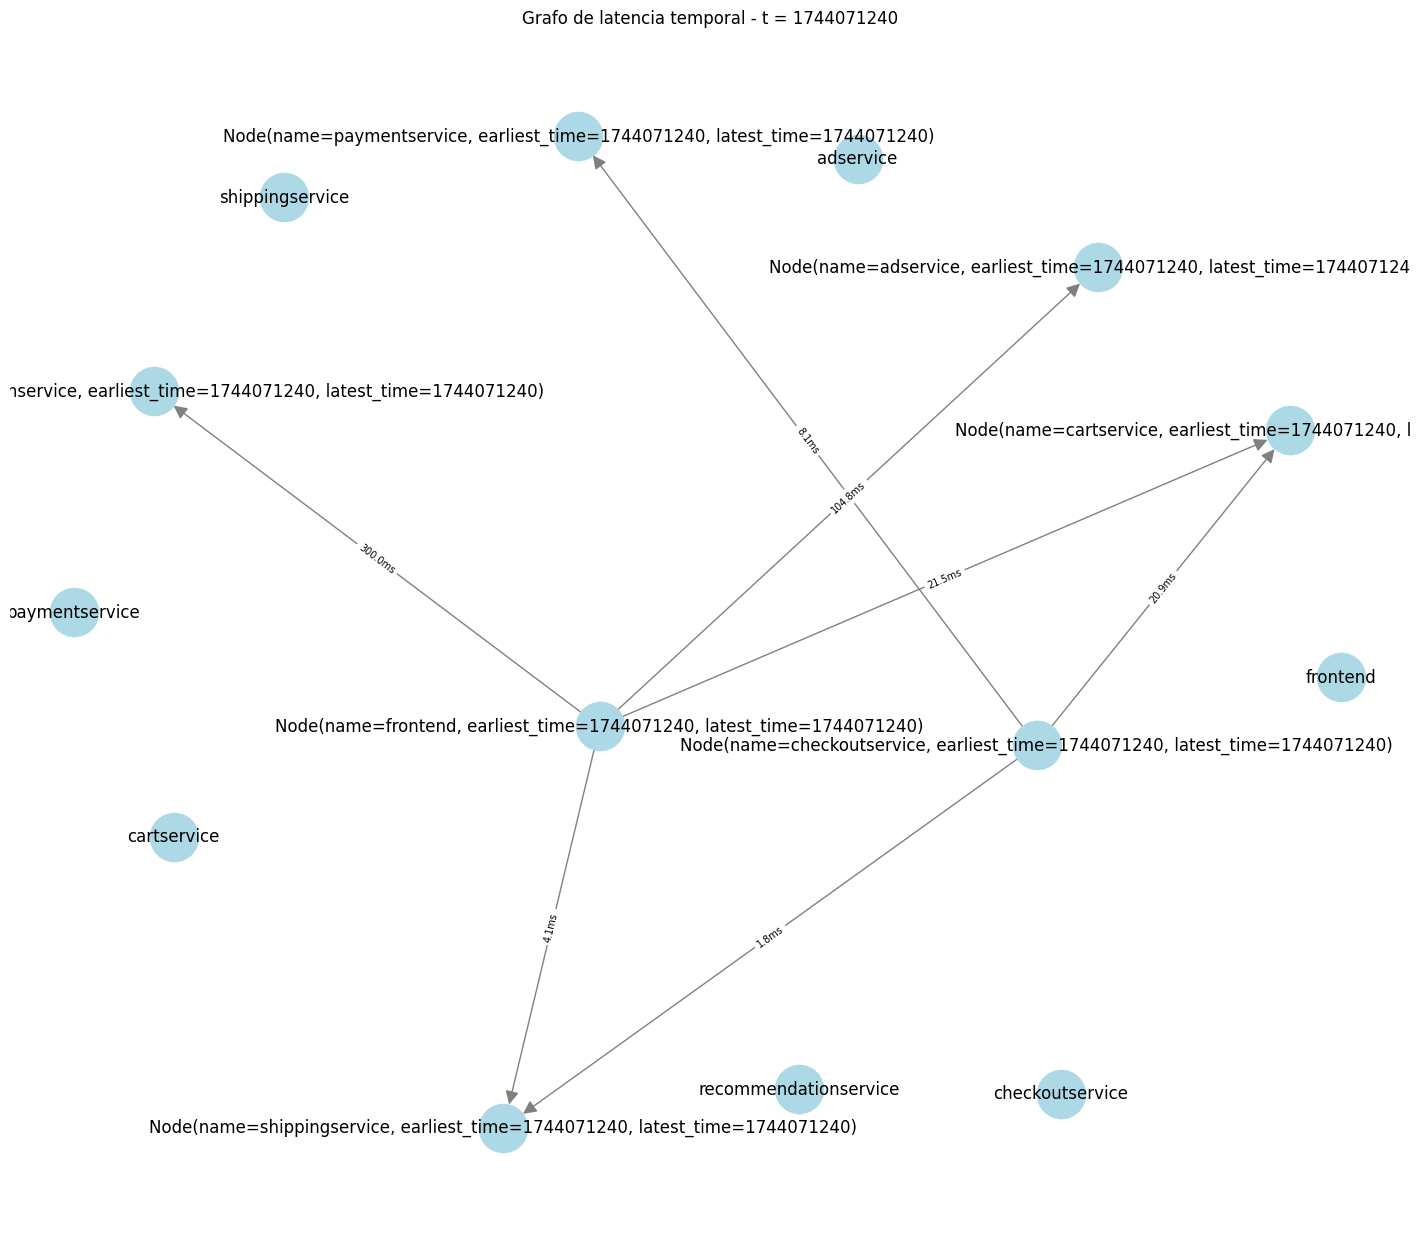

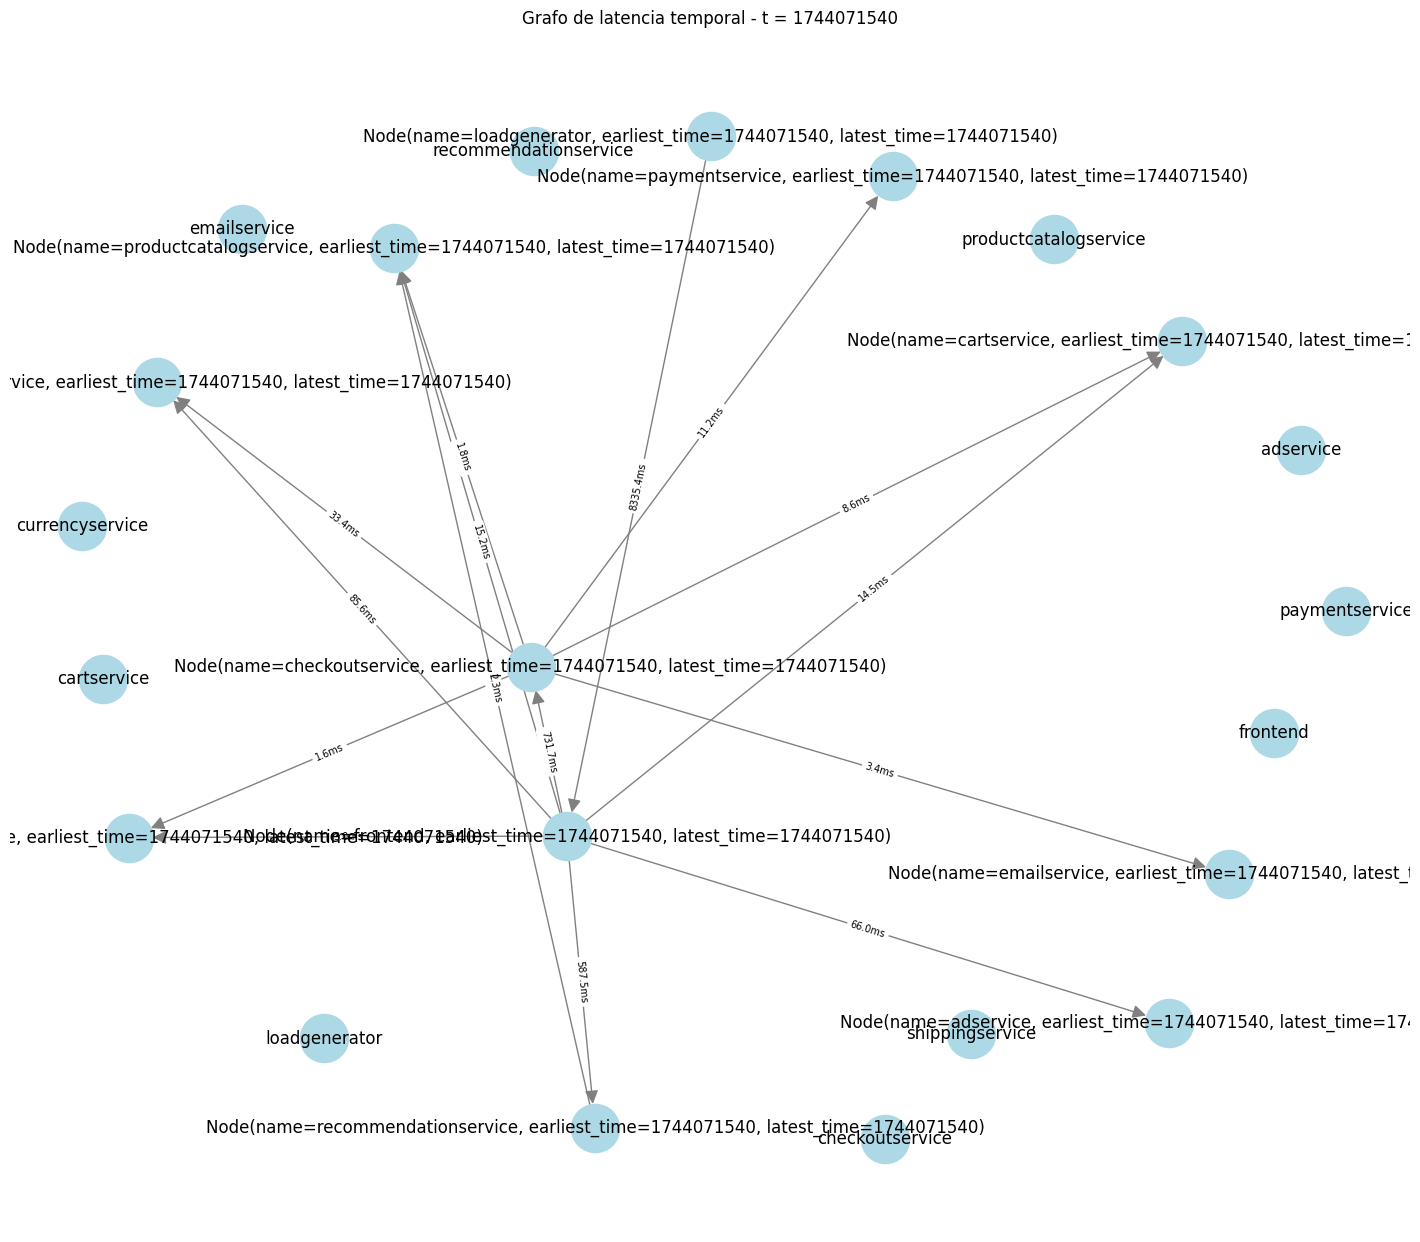

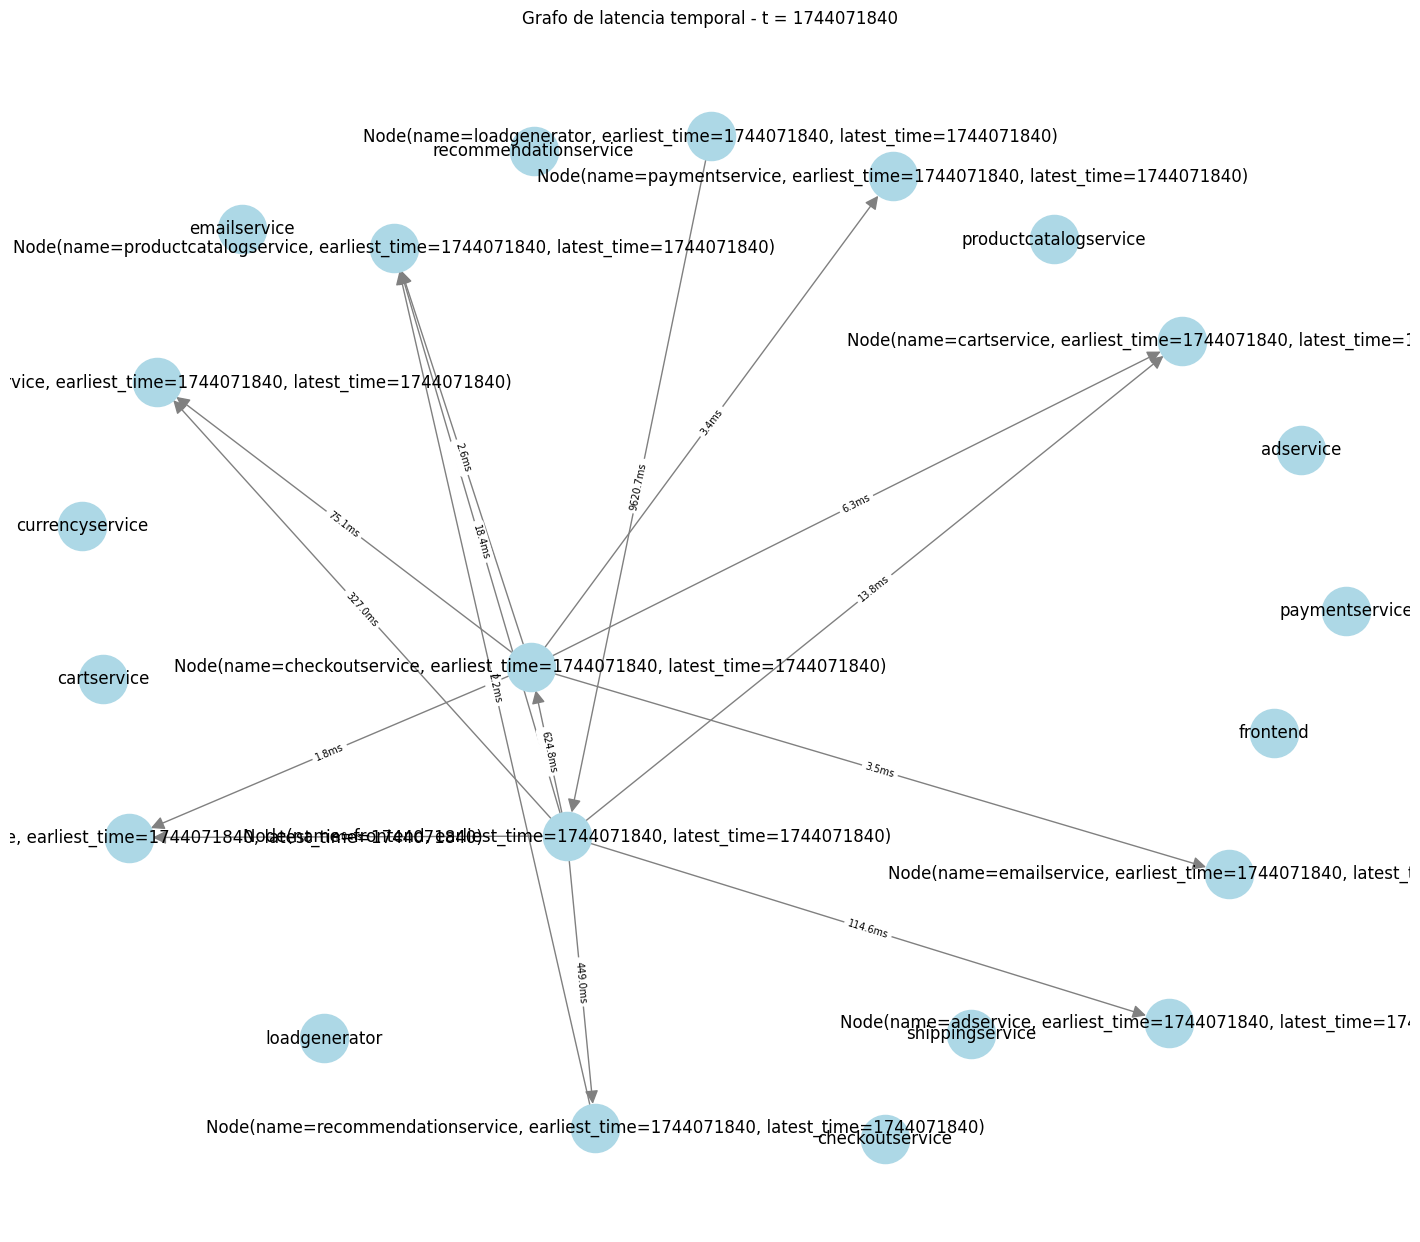

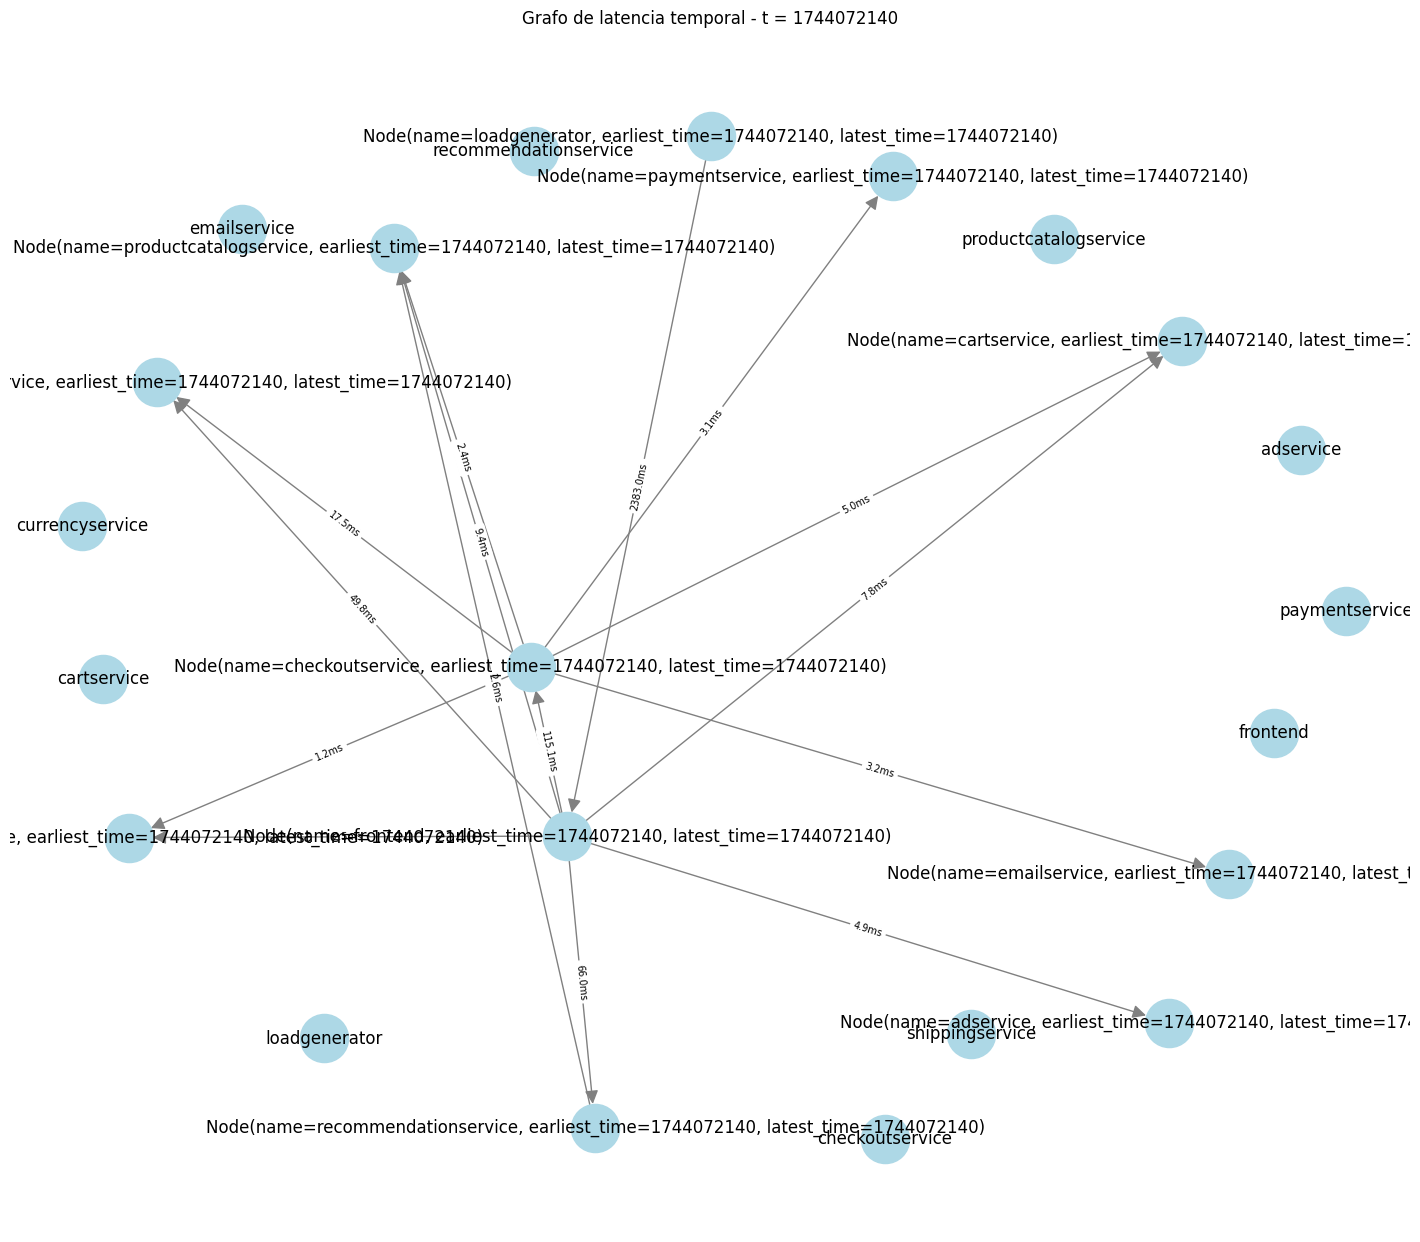

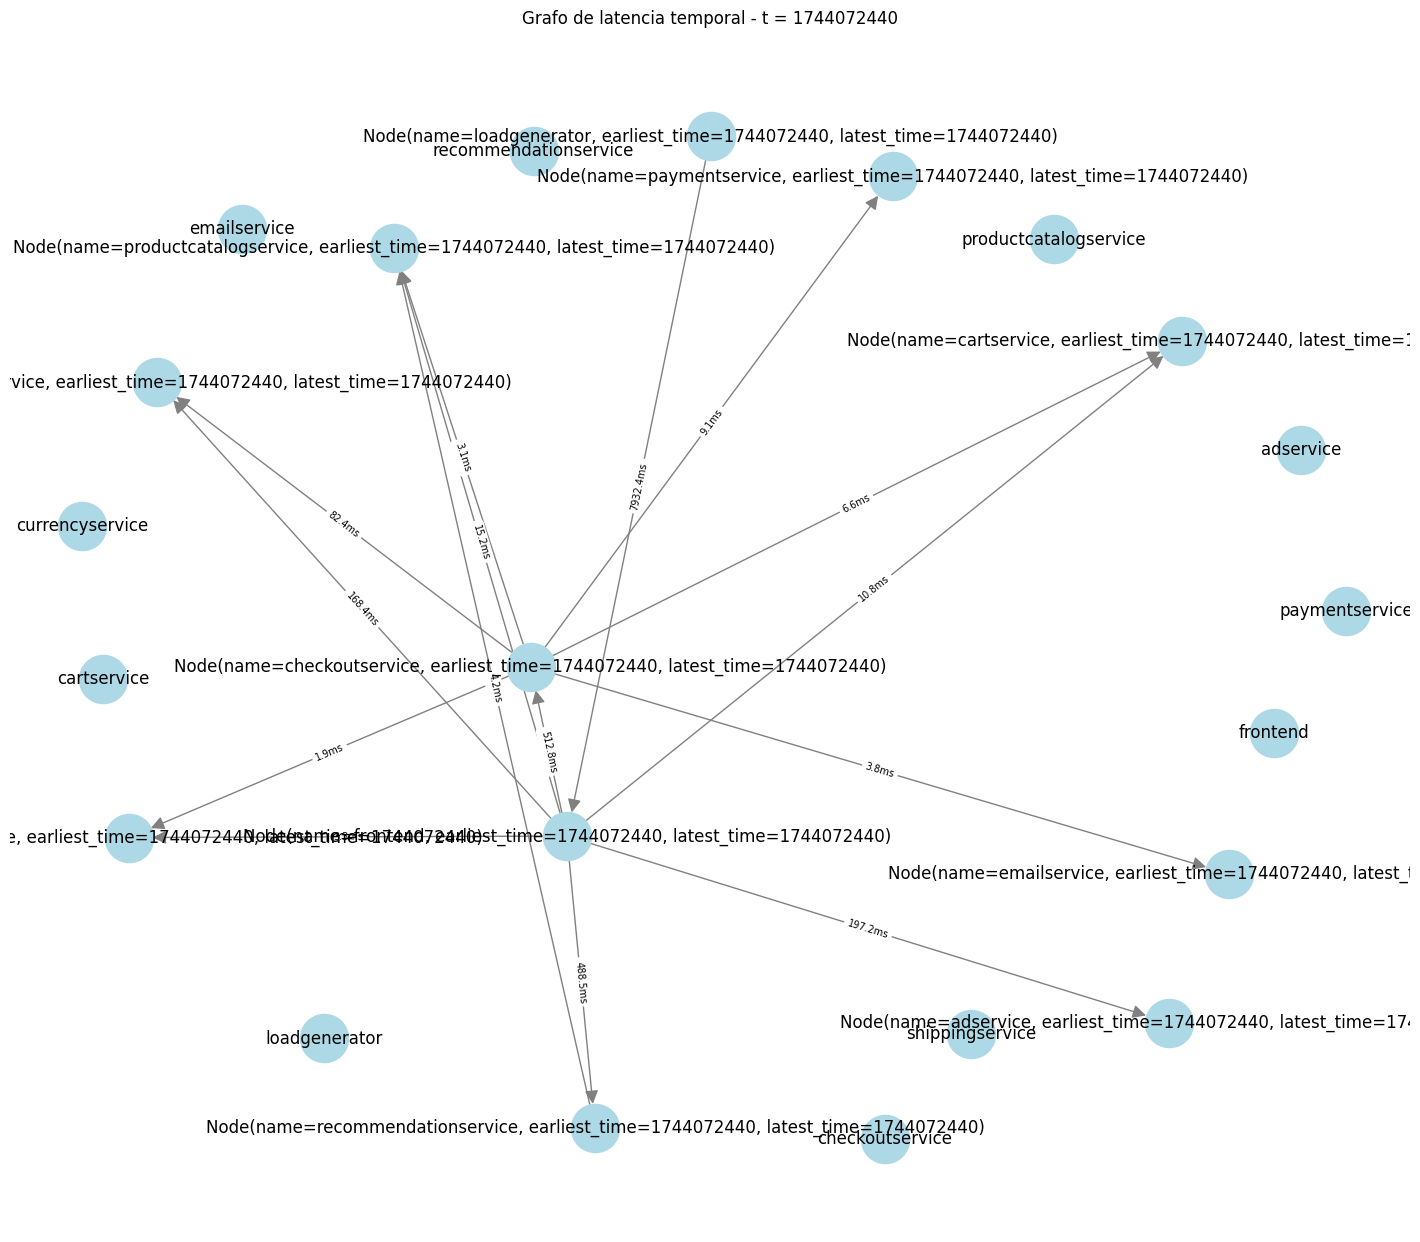

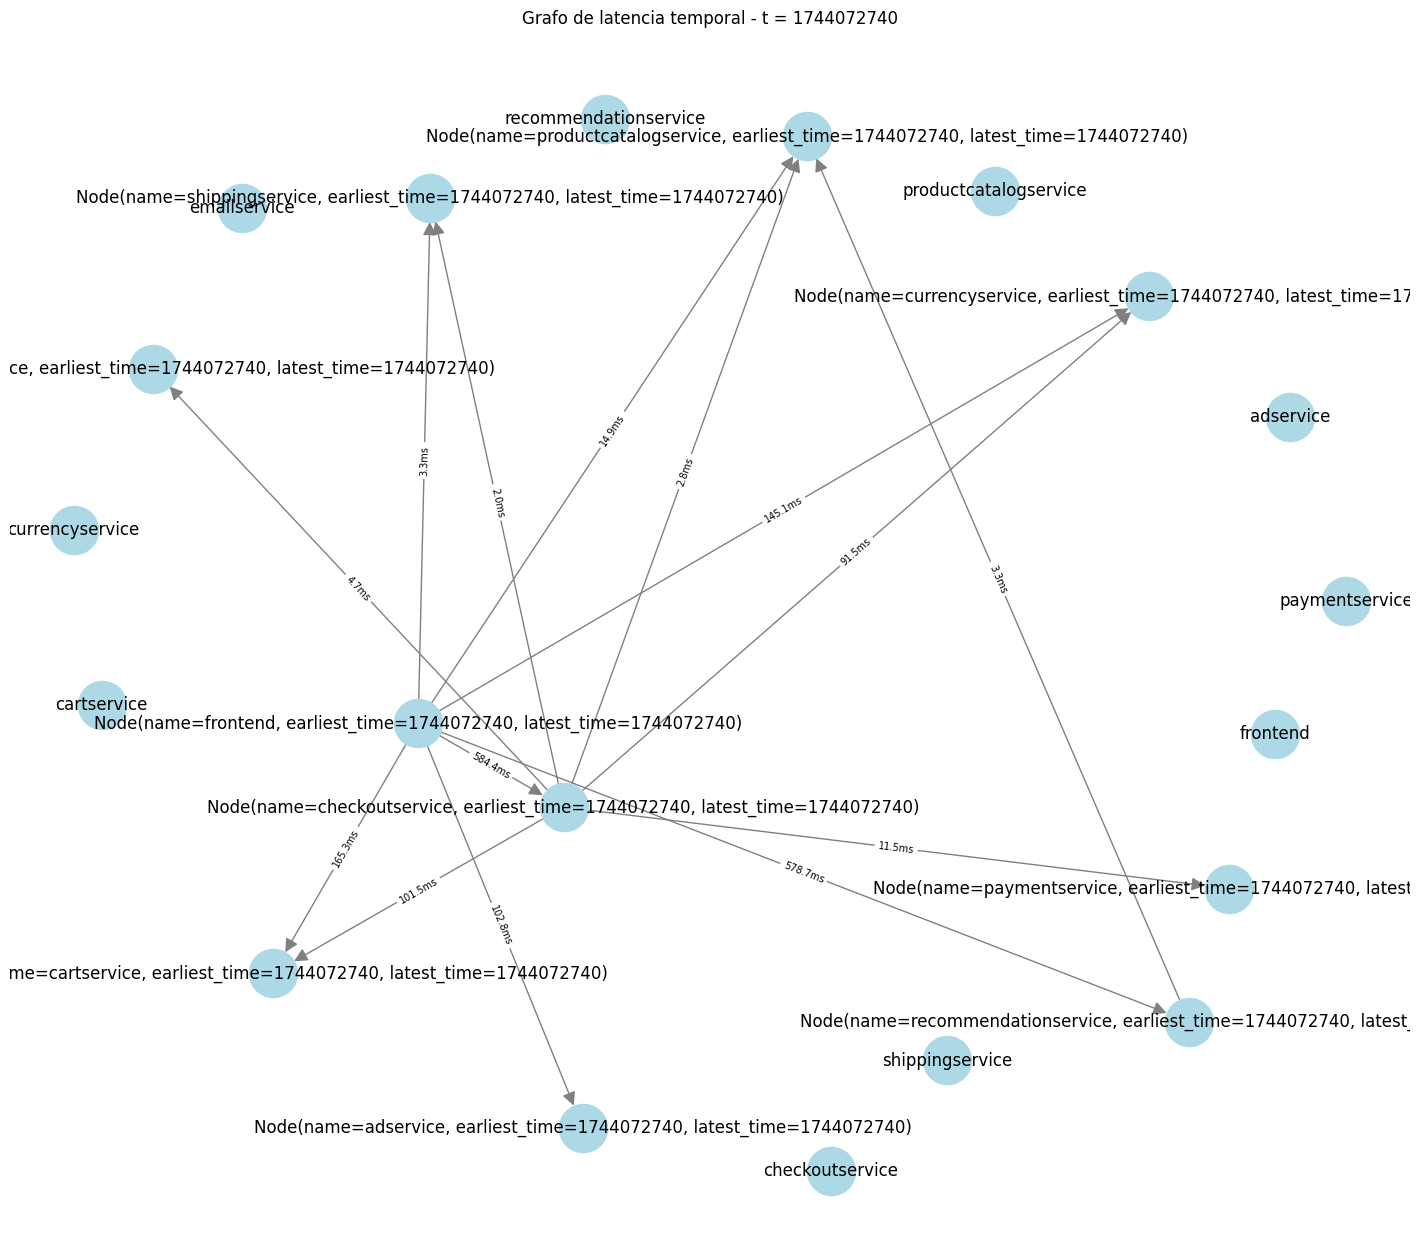

In [3]:

import networkx as nx
import matplotlib.pyplot as plt

# Visualizar snapshots cada 5 instantes
for ts in sorted(df['timestamp'].unique())[::5]:
    snapshot = g.at(ts)
    G_nx = nx.DiGraph()

    for node in snapshot.nodes:
        G_nx.add_node(str(node.name))

    for edge in snapshot.edges:
        latency = edge.properties["latency"]
        G_nx.add_edge(edge.src, edge.dst, latency=latency)

    edge_labels = {(u, v): f"{G_nx[u][v]['latency']:.1f}ms" for u, v in G_nx.edges()}

    plt.figure(figsize=(14,12))
    pos = nx.spring_layout(G_nx, seed=52, k=2)
    nx.draw(G_nx, pos, with_labels=True, node_color='lightblue',
            edge_color='gray', node_size=1200, arrowsize=20)
    nx.draw_networkx_edge_labels(G_nx, pos, edge_labels=edge_labels, font_size=7)
    plt.title(f"Grafo de latencia temporal - t = {ts}")
    plt.show()


In [9]:

import pandas as pd

# Cargar los datasets
df_kpi = pd.read_csv("kiali_kpi_metrics.csv")
df_pct = pd.read_csv("kiali_latency_percentiles.csv")

# Preprocesamiento
df_kpi['time_window'] = df_kpi['time_window'].astype(str).str.strip()
df_kpi = df_kpi[df_kpi['time_window'] == "15S"].copy()
df_kpi['error_rate'] = pd.to_numeric(df_kpi['error_rate'], errors='coerce').fillna(0.0)
df_kpi = df_kpi[df_kpi['istio_request_bytes'] != 0.0]
df_kpi = df_kpi[df_kpi['new_request'] >= 0.0]
df_kpi = df_kpi.dropna(subset=["request_rate"])

# Redondear timestamps al minuto
df_kpi['timestamp'] = pd.to_datetime(df_kpi['timestamp']).dt.floor('min')
df_pct['timestamp'] = pd.to_datetime(df_pct['timestamp']).dt.floor('min')

# Merge
df = pd.merge(
    df_kpi, df_pct,
    on=['source_workload', 'destination_workload', 'timestamp'],
    how='inner',
    suffixes=('_kpi', '_pct')
)

# Etiquetado multiclase
def assign_status_multiclase(er):
    if er < 0.01:
        return 0  # Saludable
    elif er < 0.15:
        return 1  # Degradado
    else:
        return 2  # Fallo grave

df['status'] = df['error_rate_kpi'].apply(assign_status_multiclase)
df['timestamp'] = pd.to_datetime(df['timestamp']).astype(int) // 10**9  # Convertir a UNIX


In [10]:

from raphtory import Graph

# Crear grafo
g = Graph()
percentil = "p90_latency"

for _, row in df.iterrows():
    src = str(row['source_workload'])
    dst = str(row['destination_workload'])
    ts = int(row['timestamp'])
    g.add_node(timestamp=1, id=src)
    g.add_node(timestamp=1, id=dst)
    g.add_edge(
        timestamp=ts,
        src=src,
        dst=dst,
        properties={
            "latency": row[percentil],
            "status": row["status"]
        }
    )
print("Grafo temporal construido.")


Grafo temporal construido.


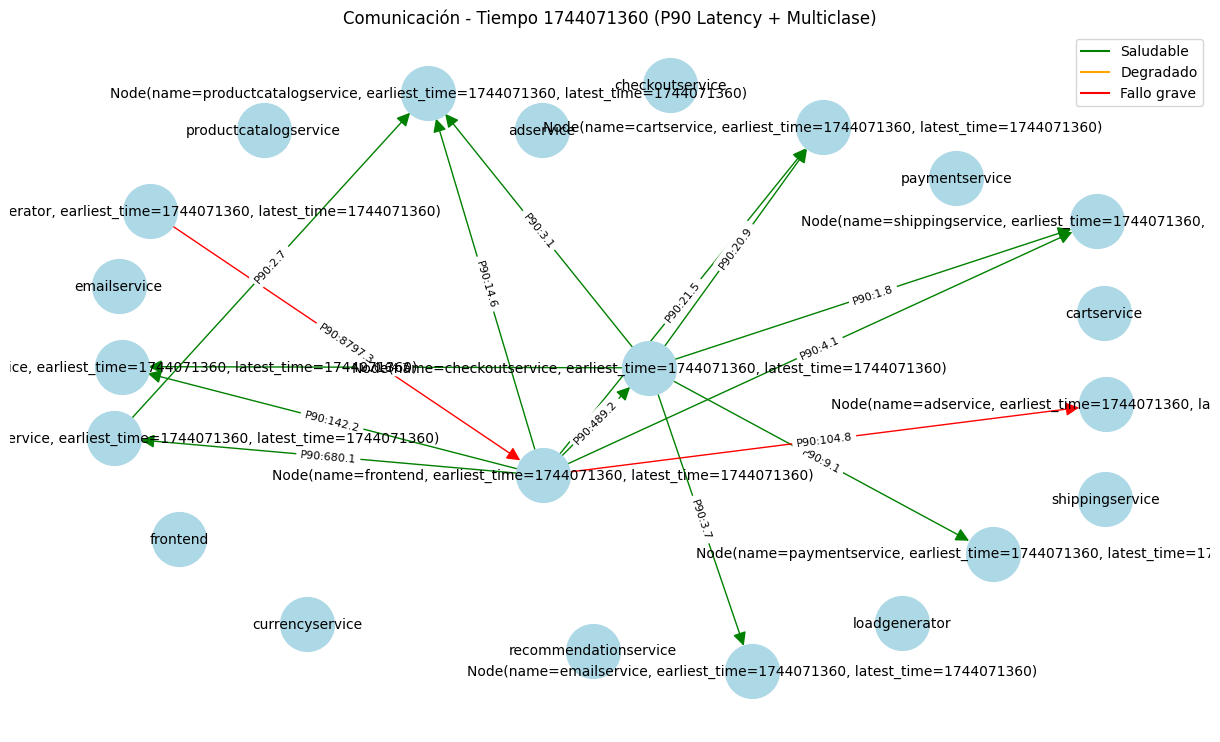

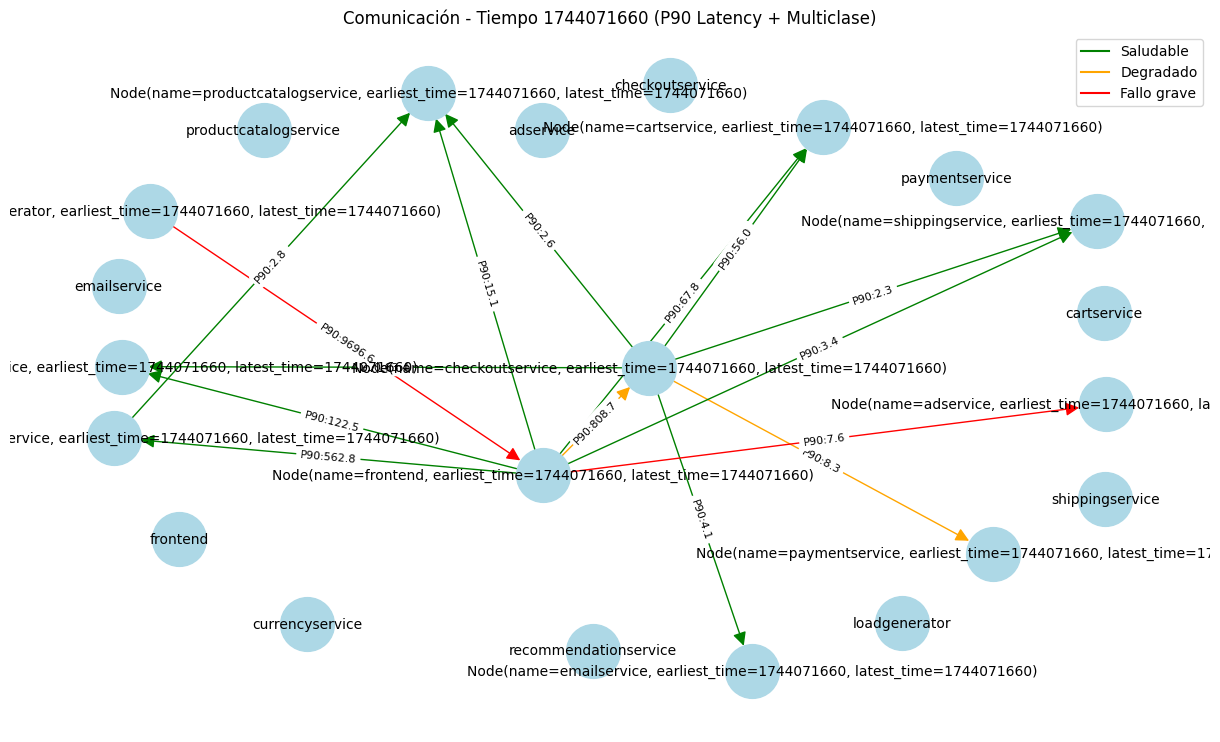

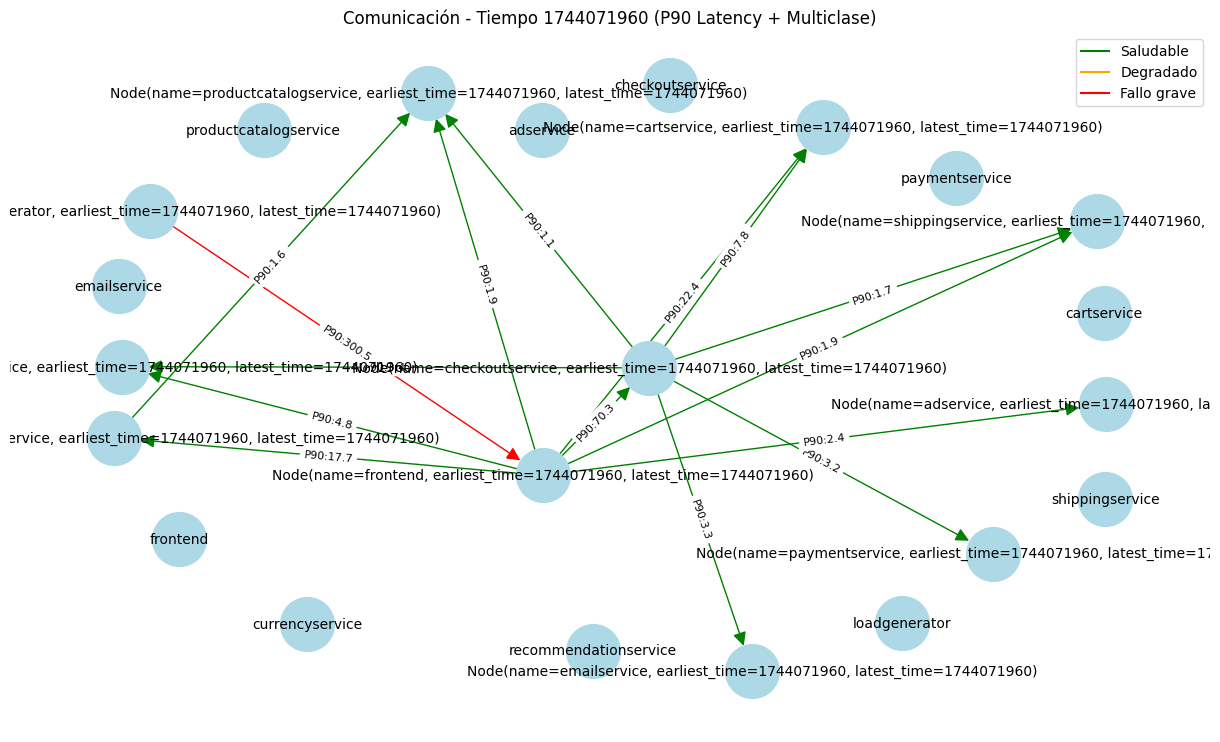

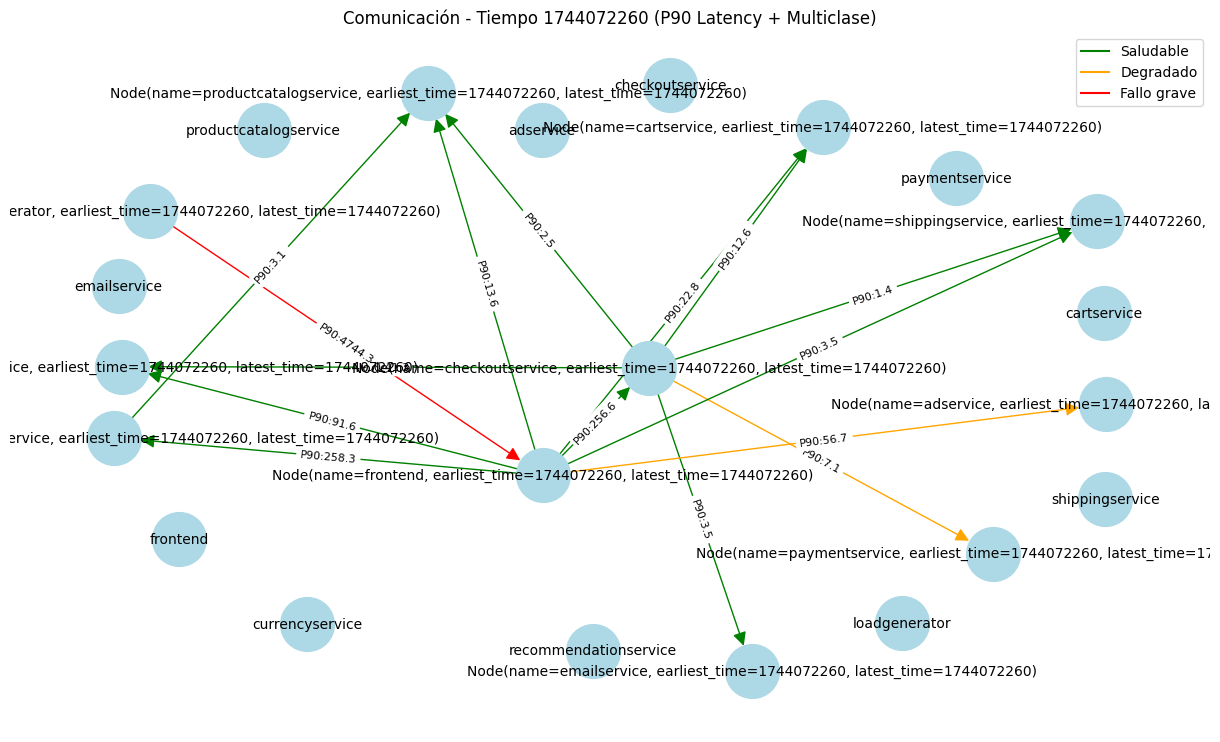

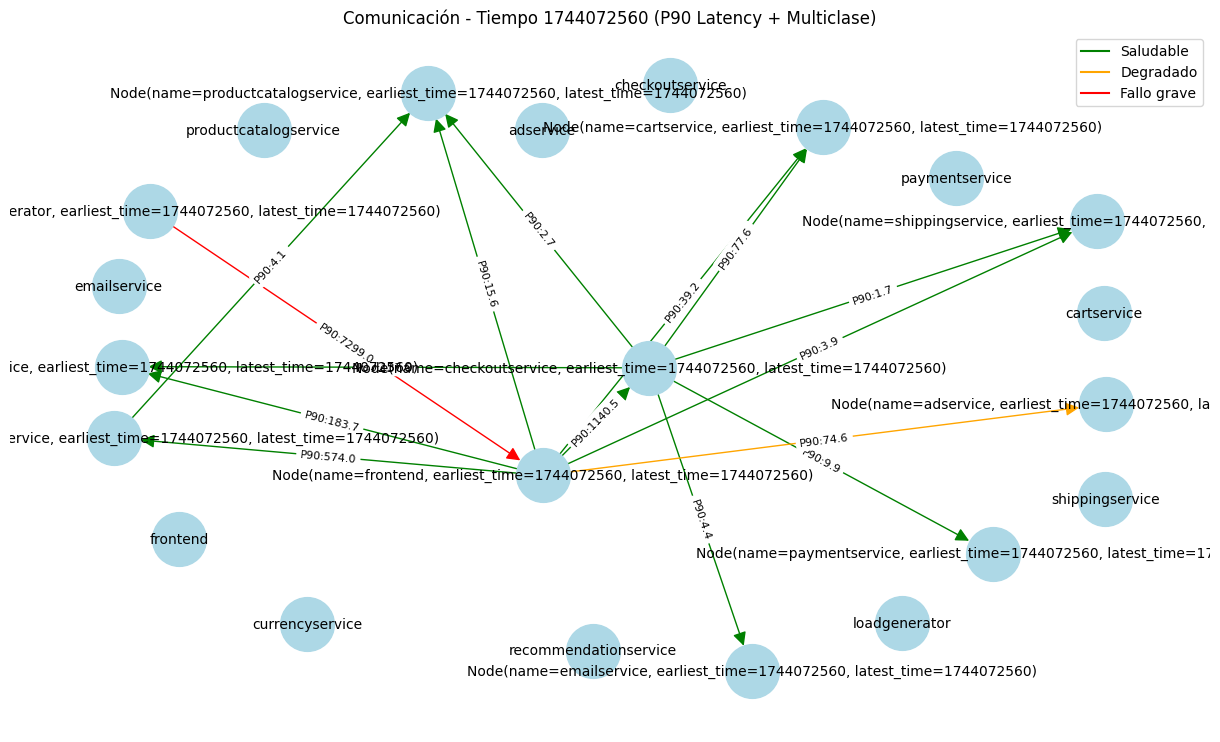

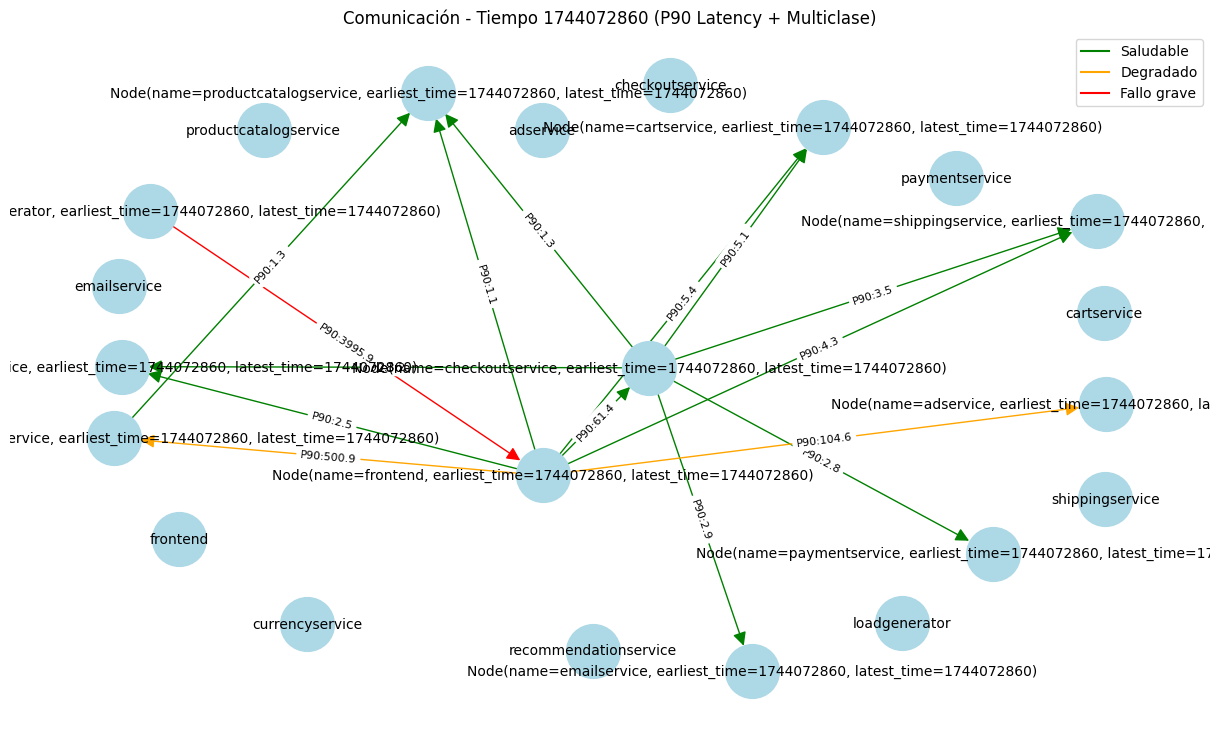

In [11]:

import networkx as nx
import matplotlib.pyplot as plt

# Visualización por snapshots
label_tag = percentil.upper().replace("_LATENCY", "")
color_map = {0: 'green', 1: 'orange', 2: 'red'}
label_map = {0: "Saludable", 1: "Degradado", 2: "Fallo grave"}

timestamps = sorted(df['timestamp'].unique())
step = 5

for i in range(0, len(timestamps), step):
    ts = timestamps[i]
    snapshot = g.at(ts)
    G = nx.DiGraph()

    for node in snapshot.nodes:
        G.add_node(str(node.name))

    for edge in snapshot.edges:
        status = edge.properties["status"]
        latency = edge.properties["latency"]
        G.add_edge(edge.src, edge.dst, status=status, latency=latency)

    edge_colors = [color_map[G[u][v]['status']] for u, v in G.edges()]
    edge_labels = {
        (u, v): f"{label_tag}:{G[u][v]['latency']:.1f}"
        for u, v in G.edges() if G[u][v]['latency'] is not None
    }

    plt.figure(figsize=(12, 7))
    pos = nx.spring_layout(G, seed=42, k=2)
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            edge_color=edge_colors, node_size=1500, font_size=10, arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    for cls, color in color_map.items():
        plt.plot([], [], color=color, label=label_map[cls])
    plt.legend(loc="upper right")
    plt.title(f"Comunicación - Tiempo {ts} ({label_tag} Latency + Multiclase)")
    plt.show()
